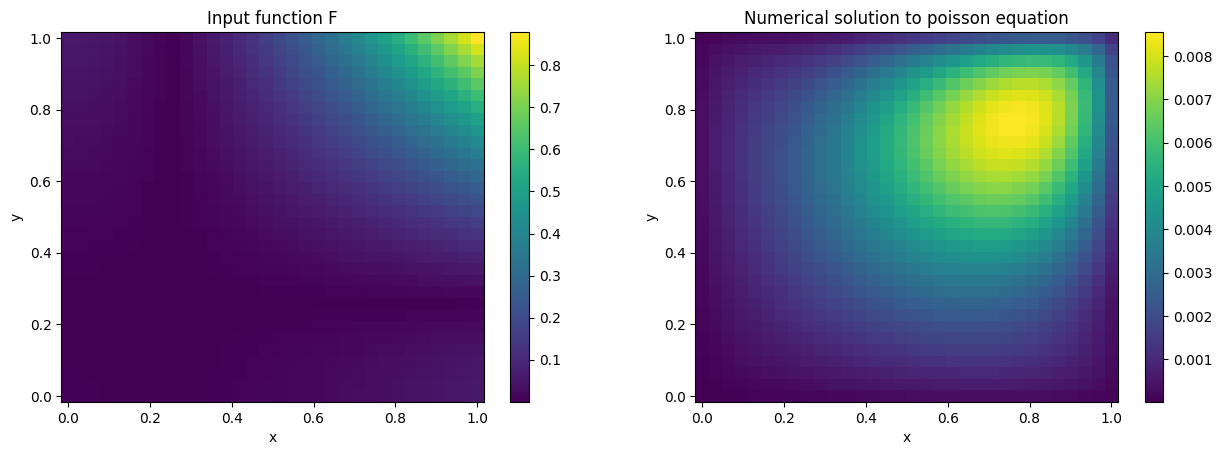

torch.Size([1, 1, 32, 32])


In [85]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
import scipy.sparse.linalg
import torch
torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

N = 32
h = 1.0 / (N - 1)
x = np.linspace(0, 1, N)
y = np.linspace(0, 1, N)
X, Y = np.meshgrid(x, y)


#SEE FORM OF OPERATOR IN DATGEN PAPER, SOLVING Lu=-f

neumann = False

# Define f
F = np.abs(X -0.5) * np.abs(Y-0.5)
#F = np.sin(X)*np.sin(Y)/np.sqrt(2*np.pi**2) - np.sin(2*X) * np.sin(Y) / np.sqrt(5*np.pi**2)
F = X-Y
#F = X**2 + Y**2
#for i in range(1,200):
    #F+= np.random.normal(0,10) *np.sin(i*X) * np.sin(i*Y) / np.sqrt((2*i**2)*np.pi**2)
#F = (X-0.5) * (Y-0.5)

F = np.abs(X -0.25) * np.abs(Y-0.25) * np.abs(X +0.25) * np.abs(Y+0.25)


F*=1

#redefine for numerical solver, which solves Lu = f, so have to redefine
F_num = -F

#numerical solver 

# Initialize the sparse matrix A
main_diagonal = np.ones(N**2) * -4 / h**2
offset_diagonals = np.ones(N**2 - 1) / h**2
offset_diagonals[N-1::N] = 0  # Fix the boundary effects where wrap-around occurs
far_diagonals = np.ones(N**2 - N) / h**2

# Create the sparse matrix A using diags
A = sp.diags(
    [main_diagonal, offset_diagonals, offset_diagonals, far_diagonals, far_diagonals],
    [0, -1, 1, -N, N], shape=(N**2, N**2), format='csr')

# Apply boundary conditions (zero boundary conditions applied by default)

if neumann:
    print(3)
    for i in range(N):
        if i == 0 or i == N-1:
            A[i,:] = A[-(i+1),:] = 0
            A[i,i] = A[-(i+1),-(i+1)] = 1/h
        if i % N == 0 or (i+1) % N == 0:
            A[i,:] = 0
            A[i,i] = 1/h

F_num = F_num.ravel()

if neumann:
    F_num[0:N] =F_num[-N:] = F_num[::N] = F_num[N-1::N] = 0

# Solve the linear system
u = scipy.sparse.linalg.spsolve(A, F_num)
U = u.reshape((N, N))


# Plotting
fig, axs = plt.subplots(nrows = 1, ncols = 2)
fig.set_figwidth(15)

fig1 = axs[0].pcolormesh(X,Y,F)
fig.colorbar(fig1)
axs[0].set_title("Input function F")
axs[0].set_xlabel("x")
axs[0].set_ylabel("y")



fig2 = axs[1].pcolormesh(X,Y,U)
fig.colorbar(fig2)
axs[1].set_title("Numerical solution to poisson equation")
axs[1].set_xlabel("x")
axs[1].set_ylabel("y")
plt.show()



#save input function

F = torch.tensor(F)[None,None,:]
print(F.shape)
torch.save(F,"../finput.pt")

In [2]:

import matplotlib.pyplot as plt
import sys, os

#from neuralop.training import Trainer 

from neuralop.utils import count_model_params
from neuralop.models import FNO2d
from neuralop import LpLoss

import torch.nn.functional as F

from models.FNO import FNO2D
from data_transforms.positional_embedding import PositionalEmbedding2D



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.cuda.empty_cache()

print(device)

cuda


In [3]:
M = 10
model_list = [FNO2D(n_modes= 12, hidden_channels=64,in_ch=3,non_linearity=F.gelu) for i in range(M)]

sys.stdout.flush()
save_dir = "./checkpoints_10000_neuralop_bothscaling_500_multi_10"

#load the model if needed
a = 0
if a == 1:
    
    for i in range(0,M): 
        state_dict = torch.load(f"{save_dir}/model_state_{i+1}.pt")
        model_list[i].load_state_dict(state_dict)


In [4]:
#optimizer
optimizer_list = [torch.optim.Adam(model_list[i].parameters(), lr=1e-3,weight_decay=1e-4) for i in range(M)]

scheduler_list = [torch.optim.lr_scheduler.StepLR(optimizer_list[i],step_size=100,gamma = 0.5) for i in range(M)]
#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=301*100)

# Creating the losses

train_loss = LpLoss(d = 2, p = 2, reductions = "sum")

sys.stdout.flush()

In [5]:
from neuralop.datasets.output_encoder import UnitGaussianNormalizer
from sklearn.preprocessing import RobustScaler
x_train = torch.load('../../data_poisson/dirichlet_10000_32_x.pt').clone().type(torch.FloatTensor)
y_train = torch.load('../../data_poisson/dirichlet_10000_32_y.pt').clone().type(torch.FloatTensor)
y_train = y_train.unsqueeze(1)



reduce_dims = list(range(x_train.ndim))
input_encoder = UnitGaussianNormalizer(dim = reduce_dims)
input_encoder.fit(x_train)
# print(input_encoder.mean, input_encoder.std)

reduce_dims = list(range(y_train.ndim))
output_encoder = UnitGaussianNormalizer(dim = reduce_dims)
output_encoder.fit(y_train)


x_train = input_encoder.transform(x_train)
y_train = output_encoder.transform(y_train)

# input_scaler = RobustScaler()
# output_scaler = RobustScaler()
# x_train = x_train.view(x_train.shape[0],-1)
# y_train = y_train.view(y_train.shape[0],-1)
# x_train = torch.tensor(input_scaler.fit_transform(x_train).reshape(x_train.shape[0],1,32,32)).type(torch.FloatTensor)
# y_train = torch.tensor(output_scaler.fit_transform(y_train).reshape(y_train.shape[0],1,32,32)).type(torch.FloatTensor)


grid_boundaries = [[0,1],[0,1]]


x_train = PositionalEmbedding2D([[0,1],[0,1]])(x_train)

train_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(x_train, y_train),
        batch_size=100,
        shuffle=True
    )

train_loader_list = [train_loader for i in range(M)]


d:\University-local\Imperial\Term_3\Project\.venv\Lib\site-packages\torch\functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [6]:
#test set
x_test = torch.load('../../data_poisson/dirichlet_test_100_32_x.pt').clone()
y_test = torch.load('../../data_poisson/dirichlet_test_100_32_y.pt').clone()

y_test = y_test.unsqueeze(1)



#x_test = x_test.view(x_test.shape[0],-1)
#y_test = y_test.view(y_test.shape[0],-1)
#x_test = torch.tensor(input_encoder.transform(x_test).reshape(x_test.shape[0],1,32,32)).type(torch.FloatTensor)
## y_test = torch.tensor(output_scaler.transform(y_test).reshape(y_test.shape[0],1,32,32)).type(torch.FloatTensor)

x_test = input_encoder.transform(x_test)

y_test = output_encoder.transform(y_test)

x_test = PositionalEmbedding2D([[0,1],[0,1]])(x_test)



test_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(x_test, y_test),
        batch_size=10,
        shuffle=True
    )


test_loader_list = [test_loader for i in range(M)]

eval_loss = train_loss

In [7]:
from callbacks.checkpointcallback_ensemble import CheckpointCallbackEnsemble
from callbacks.loggercallback_ensemble import LoggerCallbackEnsemble
from callbacks.loggercallback import LoggerCallback



ckpt = CheckpointCallbackEnsemble(save_dir=save_dir,
                                       save_freq=10)
logger = LoggerCallbackEnsemble(save_dir=save_dir, n_models = M)

from training.trainer_ensemble import Trainer_Ensemble
trainer = Trainer_Ensemble(model_list=model_list, n_epochs=501,
                  device=device,
                  callbacks=[ckpt,logger],
                  log_test_interval=1,
                  verbose=True)

In [8]:

trainer.train(train_loader_list=train_loader_list,
              test_loaders_list=test_loader_list,
              optimizer_list=optimizer_list,
              scheduler_list=scheduler_list, 
              regularizer=None, 
              training_loss=train_loss,
              eval_losses=eval_loss
              )

Model 0 - Train Epoch: 0 	Loss: 75.199348
Test set: Average loss: 6.2688

Model saved at epoch 0.
Model 1 - Train Epoch: 0 	Loss: 76.769288
Test set: Average loss: 6.6571

Model saved at epoch 0.
Model 2 - Train Epoch: 0 	Loss: 76.639790
Test set: Average loss: 6.3445

Model saved at epoch 0.
Model 3 - Train Epoch: 0 	Loss: 77.771351
Test set: Average loss: 6.6474

Model saved at epoch 0.
Model 4 - Train Epoch: 0 	Loss: 76.126394
Test set: Average loss: 6.3976

Model saved at epoch 0.
Model 5 - Train Epoch: 0 	Loss: 77.281169
Test set: Average loss: 6.5847

Model saved at epoch 0.
Model 6 - Train Epoch: 0 	Loss: 75.966133
Test set: Average loss: 6.0635

Model saved at epoch 0.
Model 7 - Train Epoch: 0 	Loss: 75.709365
Test set: Average loss: 7.3246

Model saved at epoch 0.
Model 8 - Train Epoch: 0 	Loss: 76.366627
Test set: Average loss: 7.0689

Model saved at epoch 0.
Model 9 - Train Epoch: 0 	Loss: 76.051824
Test set: Average loss: 6.3554

Model saved at epoch 0.
Model 0 - Train Epoc

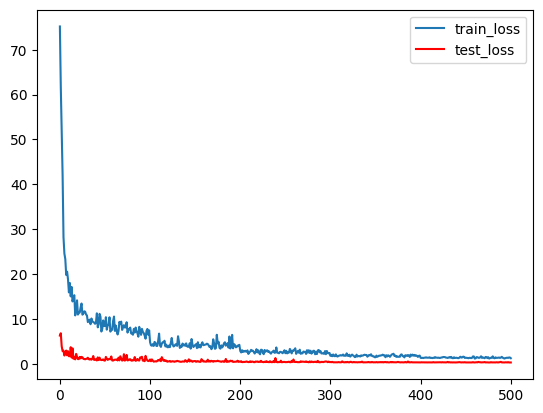

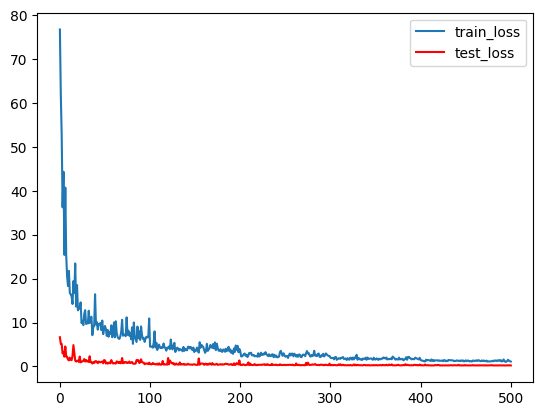

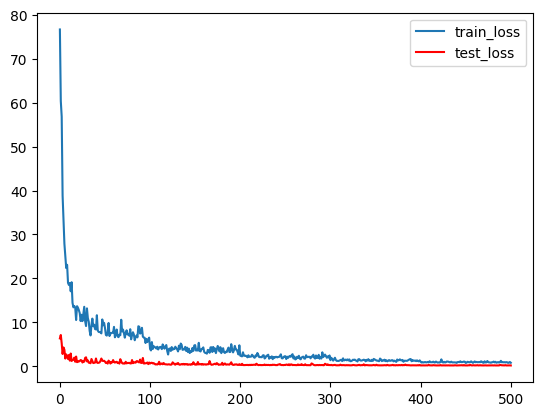

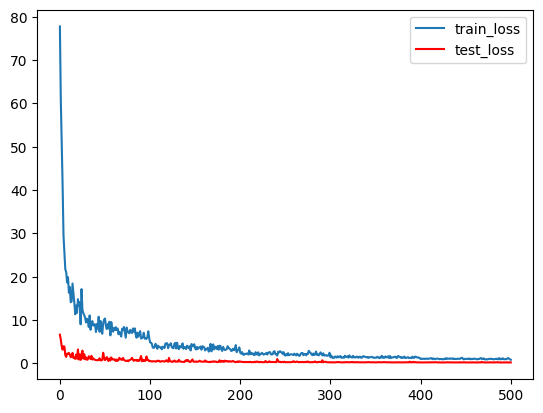

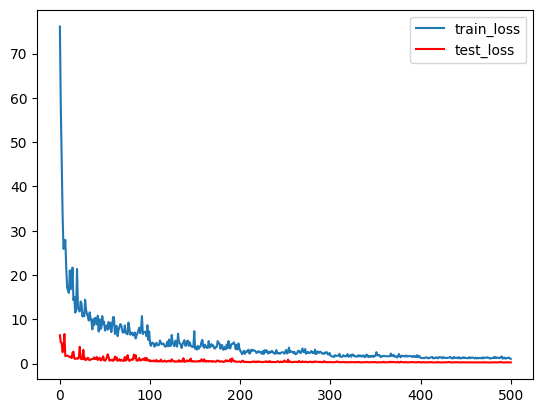

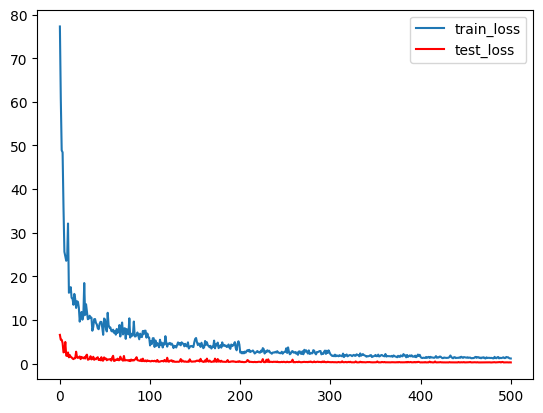

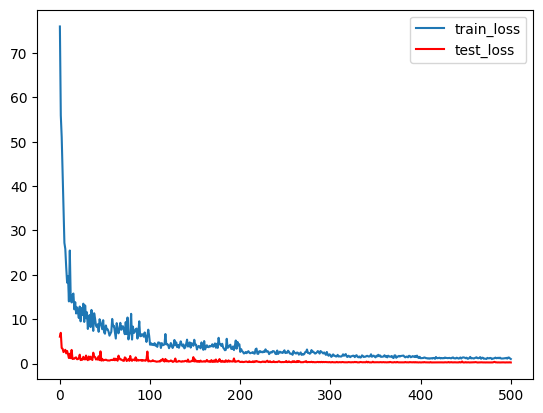

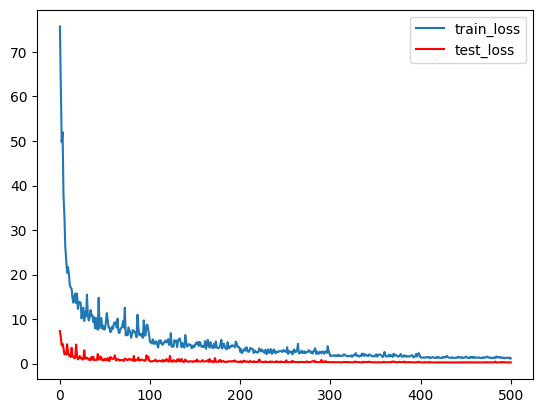

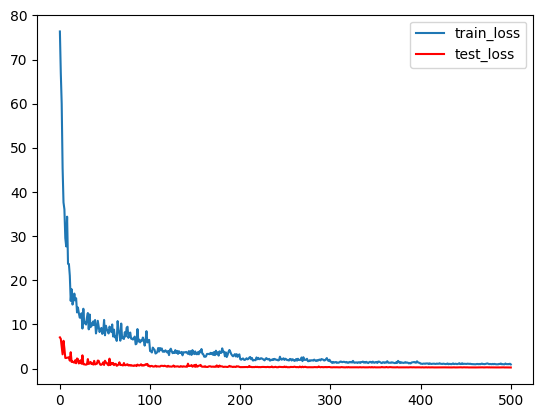

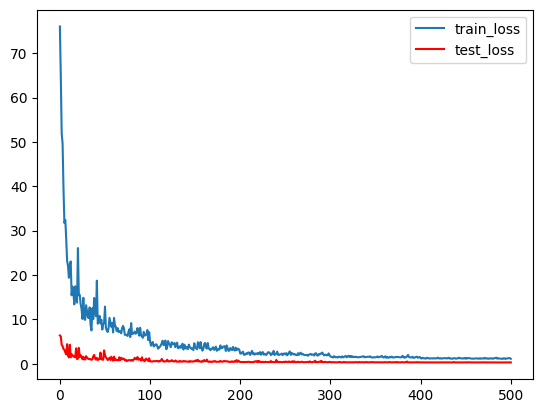

In [16]:
import pandas as pd
losses = [pd.read_csv(f"{save_dir}/loss_{i+1}.csv") for i in range(M)]





for i in range(M):
    plt.plot(np.arange(0,len(losses[i]),1),losses[i]["Train Loss"],"-",label="train_loss")
    plt.plot(np.arange(0,len(losses[i]),1),losses[i]["Test Loss"],"-r",label="test_loss")
    plt.legend()
    plt.show()

C:\Users\frase\AppData\Local\Temp\ipykernel_30472\828839653.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  out = [torch.tensor(output_encoder.inverse_transform(out[i].detach().cpu())).to(device) for i in range(M)]
C:\Users\frase\AppData\Local\Temp\ipykernel_30472\828839653.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  U = torch.tensor(U).clone().to(device)


torch.Size([32, 32])
tensor(0.5369, device='cuda:0', dtype=torch.float64)


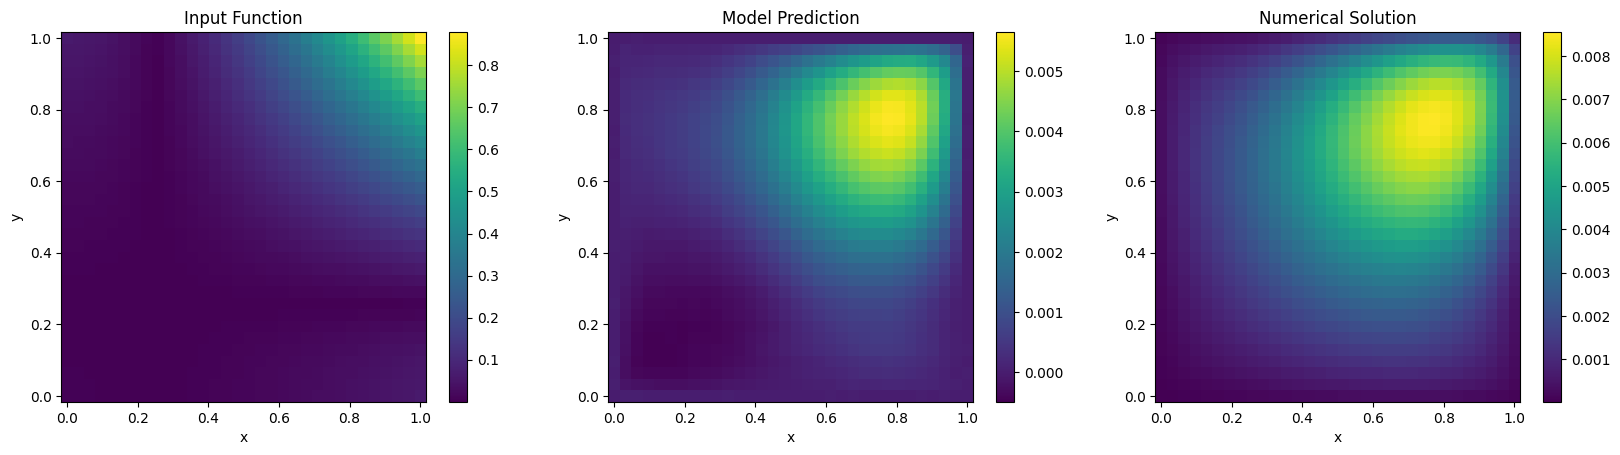

In [101]:
#prediction time for f


for i in range(M): model_list[i].eval().to(device) 



sample = torch.load("../finput.pt").clone().type(torch.FloatTensor)



sample_scaled = input_encoder.transform(sample)




#preprocessing

sample_scaled = PositionalEmbedding2D(grid_boundaries=grid_boundaries)(sample_scaled).to(device)

out = [model_list[i](sample_scaled).to(device) for i in range(M)]
#return to original scale
out = [torch.tensor(output_encoder.inverse_transform(out[i].detach().cpu())).to(device) for i in range(M)]

mu_unseen = torch.mean(torch.stack([out[i] for i in range(M)]),dim=0).to(device)
var_unseen = torch.mean(torch.stack([torch.square(out[i] - mu_unseen) for i in range(M)], dim = 0),dim=0)



U = torch.tensor(U).clone().to(device)
print(U.shape)
#U_scaled = output_encoder.transform(U.unsqueeze(0).unsqueeze(0).cpu()).to(device)

print(train_loss(mu_unseen,(U)))



# Plotting
fig, axs = plt.subplots(nrows = 1, ncols = 3,gridspec_kw={'width_ratios': [1, 1, 1]})
fig.set_figwidth(20)


fig0 = axs[0].pcolormesh(X,Y,sample[0,0,:,:].cpu().detach().numpy())
fig.colorbar(fig0)
axs[0].set_title("Input Function")
axs[0].set_xlabel("x")
axs[0].set_ylabel("y")

#prediction
fig1 = axs[1].pcolormesh(X,Y,mu_unseen[0,0,:,:].cpu().detach().numpy())
fig.colorbar(fig1)
axs[1].set_title("Model Prediction")
axs[1].set_xlabel("x")
axs[1].set_ylabel("y")



#actual
#fig2 = axs[2].pcolormesh(X,Y,U.unsqueeze(0).unsqueeze(0))[0,0,:,:].cpu())
fig2 = axs[2].pcolormesh(X,Y,U.cpu())
fig.colorbar(fig2)
axs[2].set_title("Numerical Solution")
axs[2].set_xlabel("x")
axs[2].set_ylabel("y")
plt.show()


C:\Users\frase\AppData\Local\Temp\ipykernel_30472\1235151153.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  out = [torch.tensor(output_encoder.inverse_transform(out[i].detach().cpu())).to(device) for i in range(M)]


tensor(0.0089, device='cuda:0')


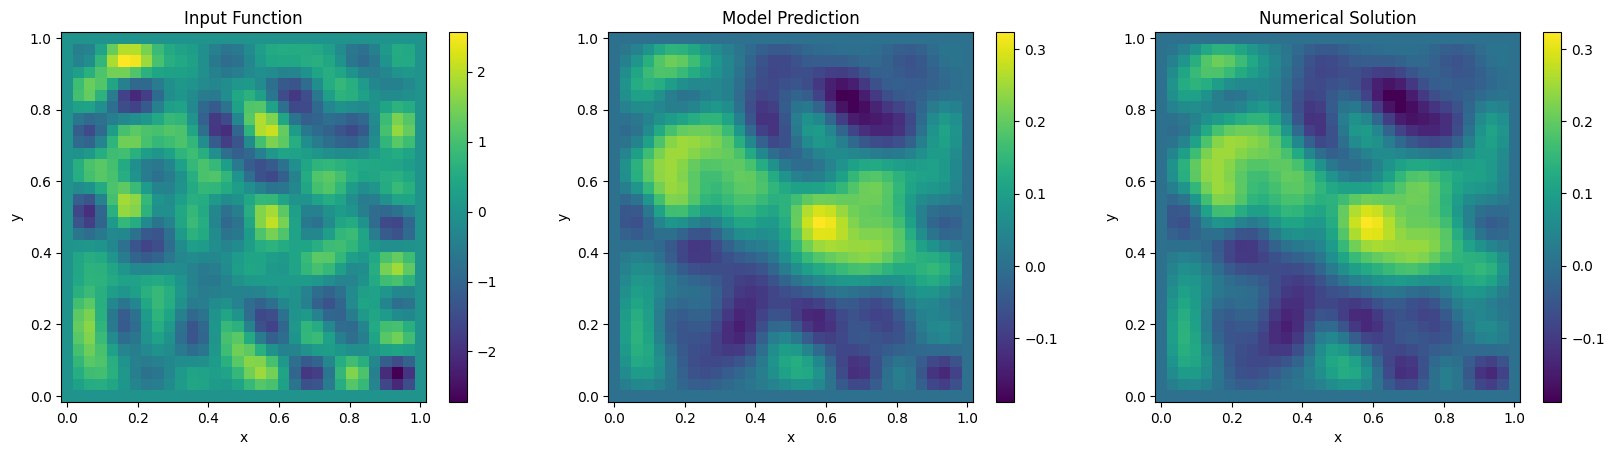

In [102]:
#prediction time
i = np.random.randint(0,100)
j = np.random.randint(0,100)
sample = test_loader.dataset[i][0].unsqueeze(0).to(device)
solution_scaled = test_loader.dataset[i][1].unsqueeze(0)
solution = output_encoder.inverse_transform(solution_scaled).to(device)

#preprocessing
out = [model_list[i](sample) for i in range(M)]
out = [torch.tensor(output_encoder.inverse_transform(out[i].detach().cpu())).to(device) for i in range(M)]
mu_seen = torch.mean(torch.stack([out[i] for i in range(M)]),dim=0).to(device)
var_seen = (torch.mean(torch.stack([torch.square(out[i] - mu_seen) for i in range(M)],dim=0), dim = 0))

#print(train_loss(mu_seen,output_encoder.inverse_transform(test_loader.dataset[i][1]).to(device)))
print(train_loss(mu_seen,solution))

#print(NLL_2(*out,train_loader.dataset[i][1].to(device)))




# Plotting
fig, axs = plt.subplots(nrows = 1, ncols = 3,gridspec_kw={'width_ratios': [1, 1, 1]})
fig.set_figwidth(20)

fig0 = axs[0].pcolormesh(X,Y,test_loader.dataset[i][0].unsqueeze(0).to(device)[0,0,:,:].cpu().detach().numpy())
fig.colorbar(fig0)
axs[0].set_title("Input Function")
axs[0].set_xlabel("x")
axs[0].set_ylabel("y")

#prediction
fig1 = axs[1].pcolormesh(X,Y,mu_seen[0,0,:,:].cpu().detach().numpy())
fig.colorbar(fig1)
axs[1].set_title("Model Prediction")
axs[1].set_xlabel("x")
axs[1].set_ylabel("y")


#actual
fig2 = axs[2].pcolormesh(X,Y,solution[0,0,:,:].cpu().detach().numpy())
fig.colorbar(fig2)
axs[2].set_title("Numerical Solution")
axs[2].set_xlabel("x")
axs[2].set_ylabel("y")
plt.show()


In [94]:
var_unseen[0,0,10:16,10:16]

tensor([[0.0002, 0.0002, 0.0002, 0.0003, 0.0003, 0.0003],
        [0.0002, 0.0002, 0.0003, 0.0003, 0.0003, 0.0003],
        [0.0002, 0.0002, 0.0003, 0.0003, 0.0003, 0.0003],
        [0.0002, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003],
        [0.0002, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003],
        [0.0002, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003]], device='cuda:0',
       grad_fn=<SliceBackward0>)

In [99]:
var_seen[0,0,10:16,10:16]

tensor([[0.0032, 0.0033, 0.0045, 0.0057, 0.0075, 0.0058],
        [0.0021, 0.0045, 0.0042, 0.0060, 0.0059, 0.0046],
        [0.0016, 0.0034, 0.0033, 0.0039, 0.0041, 0.0050],
        [0.0009, 0.0022, 0.0024, 0.0029, 0.0040, 0.0052],
        [0.0007, 0.0011, 0.0017, 0.0025, 0.0035, 0.0051],
        [0.0010, 0.0010, 0.0011, 0.0015, 0.0026, 0.0029]], device='cuda:0',
       grad_fn=<SliceBackward0>)

In [97]:
(var_unseen<var_seen ).sum()/torch.numel(var_unseen)*100


tensor(98.5352, device='cuda:0')

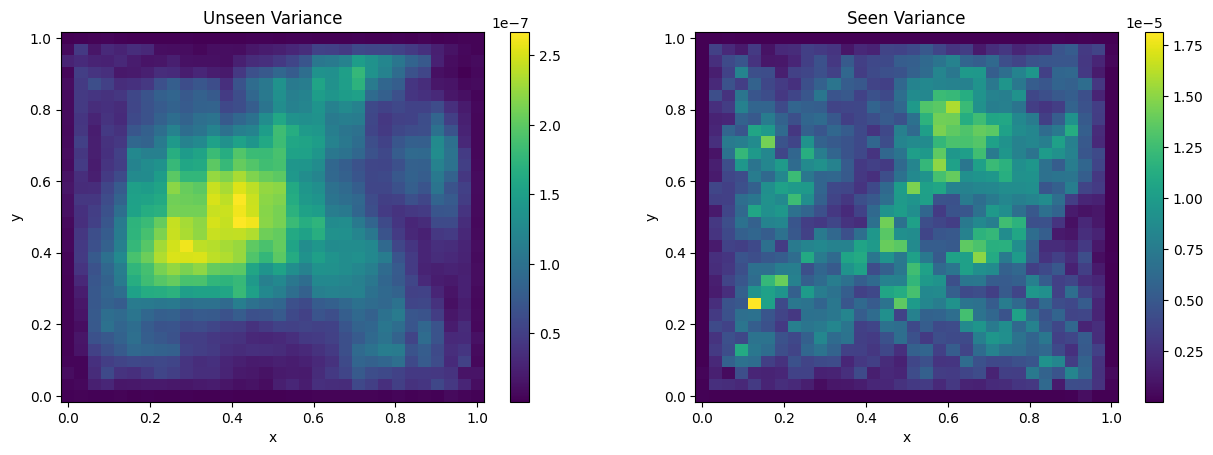

In [76]:
fig, axs = plt.subplots(nrows = 1, ncols = 2,gridspec_kw={'width_ratios': [1, 1]})
fig.set_figwidth(15)


#prediction
fig1 = axs[0].pcolormesh(X,Y,var_unseen[0,0,:,:].cpu().detach().numpy())
fig.colorbar(fig1)
axs[0].set_title("Unseen Variance")
axs[0].set_xlabel("x")
axs[0].set_ylabel("y")


#actual
fig2 = axs[1].pcolormesh(X,Y,var_seen[0,0,:,:].cpu().detach().numpy())
fig.colorbar(fig2)
axs[1].set_title("Seen Variance")
axs[1].set_xlabel("x")
axs[1].set_ylabel("y")
plt.show()